In [1]:
from time import sleep
import gym
import numpy as np
import matplotlib.pyplot as plt

In [3]:
env = gym.make("CartPole-v1")

In [4]:
env.reset()
for step in range(100):
    env.render()
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    sleep(0.1)
env.close()

C:\Users\VictorHernandez-Urbi\anaconda3\envs\env\lib\site-packages\gym\logger.py:34: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


In [5]:
def create_bins(num_bins_per_obs=10):
    bins_cart_pos = np.linspace(-4.8, 4.8, num_bins_per_obs)
    bins_cart_vel = np.linspace(-5, 5, num_bins_per_obs)
    bins_pole_angle = np.linspace(-0.418, 0.418, num_bins_per_obs)
    bins_pole_angular_vel = np.linspace(-5, 5, num_bins_per_obs)
    
    bins = np.array([bins_cart_pos, bins_cart_vel, bins_pole_angle, bins_pole_angular_vel])
    
    return bins

In [6]:
NUM_BINS = 10

In [7]:
BINS = create_bins(NUM_BINS)

In [8]:
BINS

array([[-4.8       , -3.73333333, -2.66666667, -1.6       , -0.53333333,
         0.53333333,  1.6       ,  2.66666667,  3.73333333,  4.8       ],
       [-5.        , -3.88888889, -2.77777778, -1.66666667, -0.55555556,
         0.55555556,  1.66666667,  2.77777778,  3.88888889,  5.        ],
       [-0.418     , -0.32511111, -0.23222222, -0.13933333, -0.04644444,
         0.04644444,  0.13933333,  0.23222222,  0.32511111,  0.418     ],
       [-5.        , -3.88888889, -2.77777778, -1.66666667, -0.55555556,
         0.55555556,  1.66666667,  2.77777778,  3.88888889,  5.        ]])

In [9]:
def discretize_observation(observations, bins):
    binned_observations = []
    for i, obs in enumerate(observations):
        discretized_obs = np.digitize(obs, bins[i])
        binned_observations.append(discretized_obs)
    return tuple(binned_observations)

In [10]:
observations = env.reset()

In [11]:
observations

array([-0.00561825, -0.0247225 ,  0.04869676,  0.0005973 ])

In [12]:
mapped_observation = discretize_observation(observations, BINS)

In [13]:
mapped_observation

(5, 5, 6, 5)

In [14]:
q_table_shape = (NUM_BINS, NUM_BINS, NUM_BINS, env.action_space.n)

In [15]:
q_table = np.zeros(q_table_shape)

In [24]:
q_table

array([[[[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        ...,

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]]],


       [[[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
   

In [16]:
def epsilon_greedy_action_selection(epsilon, q_table, discrete_state):
    random_number = np.random.random()
    # exploitation
    if random_number > epsilon:
        state_row = q_table[discrete_state, :]
        action = np.argmax(state_row)
    # exploration
    else:
        action = env.action_space.sample()
        
    return action

In [17]:
def compute_next_q_value(old_q_value, reward, next_optimal_q_value):
    return old_q_value + ALPHA * (reward + GAMMA * next_optimal_q_value - old_q_value)

In [18]:
EPOCHS = 20000
ALPHA = 0.8
GAMMA = 0.9

In [19]:
epsilon = 1.0
BURN_IN = 1
EPSILON_END = 10000
EPSILON_REDUCE = 0.0001

In [20]:
def reduce_epsilon(epsilon, epoch):
    if BURN_IN <= epoch <= EPSILON_END:
        epsilon -= EPSILON_REDUCE
    return epsilon

In [21]:
def fail(done, points, reward):
    if done and points < 150:
        reward = -200
    return reward

IndexError: too many indices for array: array is 4-dimensional, but 5 were indexed

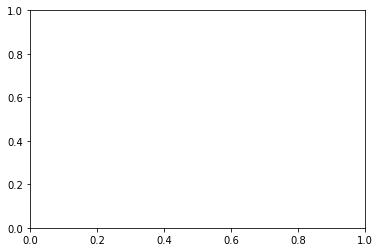

In [25]:
#### visualization ######
log_interval = 500
render_interval = 30000

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.canvas.draw()
#########################

points_log = []
mean_points_log = []
epochs = []

for ep in range(EPOCHS):
    initial_state = env.reset()
    discretized_state = discretize_observation(initial_state, BINS)
    
    done = False
    points = 0
    
    epochs.append(ep)
    
    while not done:
        action = epsilon_greedy_action_selection(epsilon, q_table, discretized_state)
        next_state, reward, done, info = env.step(action)
        
        reward = fail(done, points, reward)
        
        next_state_discretized = discretize_observation(next_state, BINS)
        old_q_value = q_table[discretized_state + (action,)]
        next_optimal_q_value = np.max(q_table[next_state_discretized])
        
        next_q_value = compute_next_q_value(old_q_value, reward, next_optimal_q_value)
        q_table[discretized_state + (action, )] = next_q_value
        
        discretized_state = next_state_discretized
        points += 1
        
    
    epsilon = reduce_epsilon(epsilon, ep)
    points_log.append(points)
    running_mean = round(np.mean(points_log[-30:]), 2)
    mean_points_log.append(running_mean)
    
    #####
    if ep % log_interval == 0:
        ax.clear()
        ax.scatter(EPOCHS, points_log)
        ax.plot(EPOCHS, points_log)
        ax.plot(EPOCHS, mean_points_log, label=format("Running mean: {}", running_mean))
        plt.legend()
        fig.canvas.draw()
env.close()

In [26]:
q_table.shape

(10, 10, 10, 2)

In [28]:
(action,)

(1,)